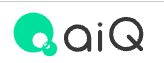

[disclaimer](../disclaimer.txt/)

# Data Handler

This component is responsible for retrieving and storing data from a database.  <br>
It includes functionalities for processing the stored data to create new features and for visualizing the data in graphs.

## 0. Preparation

In [1]:
# Import the libraries needed for the sample.
import os
import pandas as pd

### Import the Data Handler (DAL)

In [2]:
from aiq_strategy_robot.data.data_accessor import DAL
sdh = DAL()

### Import helper functions

When loading data from data sources (e.g., **factset**, **finnhub**), the handler's helper functions are used.<br>
Below, we import the helper functions used in this sample.

In [3]:
from aiq_strategy_robot.data.FINNHUB import (
    load_finnhub_symbol_lookup,
    load_finnhub_fundamental, 
    load_finnhub_equity_data, 
)

from aiq_strategy_robot.data.ALTERNATIVE import (
    load_alternative_aiq_pos_csmr_goods_universe, 
    load_alternative_aiq_pos_csmr_goods_data
)

## 1. symbol_lookup

This is the endpoint used to look up the symbol codes of each data vendor from the general Bloomberg ticker codes.

In [4]:
# Example: `finnhub loader`'s `symbol_lookup`
tickers = ['4661 JP', '9983 JP', 'AAPL US']

df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=['4661 JP', '9983 JP', 'AAPL US']).retrieve()
display(df_symbols_finnhub.head())

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,TICKER
0,JPY,ORIENTAL LAND CO LTD,4661.T,BBG000HPZ220,None,XJPX,BBG001S9BPK7,4661.T,,Common Stock,4661 JP
1,JPY,FAST RETAILING CO LTD,9983.T,BBG000CLY9R3,None,XJPX,BBG001S82FV9,9983.T,,Common Stock,9983 JP
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL.T,NaN,NaN,AAPL US


### Retrieve symbols that exist in both alternative data and Finnhub. 

#### Get the universe of aiQ POS csmr goods from alternative data.

In [5]:
sdh = DAL()
aiq_pos_universe = load_alternative_aiq_pos_csmr_goods_universe(sdh).retrieve()
aiq_pos_universe.head()

,FIGI,TICKER
0,BBG000BFX4L5,3002
1,BBG000GG5CL1,2923
2,BBG0044F7Q35,2884
3,BBG000BG6F83,4523
4,BBG000F7NQW9,2917


#### Retrieve Finnhub symbols
Obtain Finnhub symbols using the Ticker from the `aiQ POS csmr goods` universe.

In [6]:
# Retrieve Symbols
df_symbols_finnhub = load_finnhub_symbol_lookup(sdh, exchange_code='T', tickers=(aiq_pos_universe.TICKER + ' JP').to_list() ).retrieve()

Extract 6 samples as an example

In [7]:
num = 6
df_symbols_finnhub = df_symbols_finnhub.dropna(subset='currency').sample(num)
display(df_symbols_finnhub)

tickers = df_symbols_finnhub.TICKER.to_list()
alt_tickers = df_symbols_finnhub.TICKER.str.split(' ').str[0].to_list()
finnhub_symbols = df_symbols_finnhub.symbol.to_list()

,currency,description,displaySymbol,figi,isin,mic,shareClassFIGI,symbol,symbol2,type,TICKER
23,JPY,BOURBON CORP,2208.T,BBG000BHVTH3,None,XJPX,BBG001S6C8K0,2208.T,,Common Stock,2208 JP
181,JPY,SHISEIDO CO LTD,4911.T,BBG000BG7YJ9,None,XJPX,BBG001S6BBD2,4911.T,,Common Stock,4911 JP
187,JPY,HABA LABORATORIES INC,4925.T,BBG000L04YN1,None,XJPX,BBG001SJTCJ7,4925.T,,Common Stock,4925 JP
234,JPY,MITSUBISHI CORP,8058.T,BBG000BB8HL3,None,XJPX,BBG001S5RNJ5,8058.T,,Common Stock,8058 JP
60,JPY,FRUTA FRUTA INC,2586.T,BBG007J7RNS8,None,XJPX,BBG002MX56K7,2586.T,,Common Stock,2586 JP
219,JPY,SHOBIDO CORP,7819.T,BBG000NTRWH2,None,XJPX,BBG001T5BH59,7819.T,,Common Stock,7819 JP


## 2. Obtain stock prices

In [8]:
sdh = DAL()

# Obtain daily data
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='D',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

7819.T: loading...: 100%|██████████| 6/6 [00:10<00:00,  1.71s/it]


close   high    low   open  volume  dividends  split_ratio
TICKER  DATETIME                                                              
2208 JP 2010-01-06  900.0  900.0  891.0  899.0    4000        0.0          1.0
        2010-01-08  922.0  922.0  907.0  907.0    4000        0.0          1.0
        2010-01-12  914.0  914.0  907.0  907.0    2000        0.0          1.0
        2010-01-13  899.0  899.0  899.0  899.0    1000        0.0          1.0
        2010-01-15  920.0  920.0  914.0  914.0    5000        0.0          1.0

In [9]:
# Obtain weekly data
load_finnhub_equity_data(
    sdh,
    symbols=finnhub_symbols,
    freq='W',
    start_datetime='2010-01-01', 
    end_datetime='2024-01-01'
).retrieve().head()

7819.T: loading...: 100%|██████████| 6/6 [00:10<00:00,  1.81s/it]


close   high    low   open   volume  dividends  \
TICKER  DATETIME                                                     
2208 JP 2010-01-06  922.0  922.0  891.0  899.0   8000.0        0.0   
        2010-01-12  920.0  920.0  899.0  907.0   8000.0        0.0   
        2010-01-18  901.0  930.0  901.0  930.0  13000.0        0.0   
        2010-01-25  920.0  949.0  920.0  946.0  10000.0        0.0   
        2010-02-02  915.0  920.0  900.0  900.0   5000.0        0.0   

                    split_ratio  
TICKER  DATETIME                 
2208 JP 2010-01-06          1.0  
        2010-01-12          1.0  
        2010-01-18          1.0  
        2010-01-25          1.0  
        2010-02-02          1.0

### Appendix

#### 1. Check the loaded data

The obtained data is registered with the handler, and each dataset is assigned a `data_id`.

In [10]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,None,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,NaN,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00


In [11]:
# Set aliases
sdh.set_alias({1: 'finhub_price_D', 2: 'finhub_price_W'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00


#### 2. Retrieve data immediately after loading with the `retrieve` method
The `retrieve` method can only obtain data that was loaded immediately before.


In [12]:
sdh.retrieve().tail()

close   high    low   open    volume  dividends  \
TICKER  DATETIME                                                      
7819 JP 2023-11-27  627.0  659.0  594.0  594.0  416100.0        0.0   
        2023-12-04  644.0  659.0  621.0  621.0  224800.0        0.0   
        2023-12-11  635.0  671.0  585.0  648.0  333200.0        0.0   
        2023-12-18  709.0  712.0  617.0  625.0  297100.0        0.0   
        2023-12-25  687.0  723.0  671.0  695.0  221500.0        0.0   

                    split_ratio  
TICKER  DATETIME                 
7819 JP 2023-11-27          1.0  
        2023-12-04          1.0  
        2023-12-11          1.0  
        2023-12-18          1.0  
        2023-12-25          1.0

#### 3. Retrieve data using the `get_raw_data` method by specifying the `data_id`.
You can retrieve registered data using the `data_id`.

In [13]:
sdh.get_raw_data(2).tail()

close         high          low         open  \
TICKER  DATETIME                                                         
8058 JP 2023-12-04  2224.664433  2330.664333  2220.997767  2306.997700   
        2023-12-11  2234.664433  2291.664367  2182.331133  2262.997733   
        2023-12-18  2217.331133  2253.997733  2186.664467  2226.331100   
        2023-12-25  2245.000000  2262.000000  2200.331133  2224.997767   
        2023-12-28          NaN          NaN          NaN          NaN   

                        volume  dividends  split_ratio  
TICKER  DATETIME                                        
8058 JP 2023-12-04  72058866.0        0.0     0.333333  
        2023-12-11  76395372.0        0.0     0.333333  
        2023-12-18  59896554.0        0.0     0.333333  
        2023-12-25  31382321.0        0.0     0.333333  
        2023-12-28         NaN        NaN     0.333333

## 3. Retrieval of Financial Data

In [14]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='ic',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

7819.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  6.64it/s]


costOfGoodsSold  depreciationAmortization  \
TICKER  DATETIME                                                
2208 JP 2014-09-30          13884.0                       5.0   
        2014-12-31          17117.0                       4.0   
        2015-03-31          16147.0                       4.0   
        2015-06-30          14820.0                       3.0   
        2015-09-30          14860.0                       3.0   

                    dilutedAverageSharesOutstanding  dilutedEPS    ebit  \
TICKER  DATETIME                                                          
2208 JP 2014-09-30                             24.0       -5.83  -337.0   
        2014-12-31                             24.0       51.37  1617.0   
        2015-03-31                             24.0       17.62  1247.0   
        2015-06-30                             24.0       22.79   725.0   
        2015-09-30                             24.0       -4.37    22.0   

                    gainLossOnDispositionOfAssets  grossIncome  \
TICKER  DATETIME                                                 
2208 JP 2014-09-30                           -2.0       8769.0   
        2014-12-31                           -7.0      12469.0   
        2015-03-31                          -34.0      12224.0   
        2015-06-30                           -1.0      10365.0   
        2015-09-30                           -1.0       9573.0   

                    interestIncomeExpense  netIncome  netIncomeAfterTaxes  \
TICKER  DATETIME                                                            
2208 JP 2014-09-30                  110.0     -140.0               -141.0   
        2014-12-31                  319.0     1233.0               1234.0   
        2015-03-31                   80.0      423.0                422.0   
        2015-06-30                  128.0      547.0                547.0   
        2015-09-30                  447.0     -105.0               -105.0   

                    nonRecurringItems  otherOperatingExpensesTotal  \
TICKER  DATETIME                                                     
2208 JP 2014-09-30               -3.0                          0.0   
        2014-12-31                0.0                          0.0   
        2015-03-31             -308.0                         -1.0   
        2015-06-30              -14.0                          1.0   
        2015-09-30             -544.0                          0.0   

                    pretaxIncome  provisionforIncomeTaxes  revenue  \
TICKER  DATETIME                                                     
2208 JP 2014-09-30        -142.0                     -1.0  22653.0   
        2014-12-31        1944.0                    710.0  29586.0   
        2015-03-31        1001.0                    579.0  28371.0   
        2015-06-30         867.0                    320.0  25185.0   
        2015-09-30         -93.0                     12.0  24433.0   

                    sgaExpense  totalOperatingExpense  \
TICKER  DATETIME                                        
2208 JP 2014-09-30      9101.0                 9106.0   
        2014-12-31     10848.0                10852.0   
        2015-03-31     10974.0                10977.0   
        2015-06-30      9636.0                 9640.0   
        2015-09-30      9548.0                 9551.0   

                    totalOtherIncomeExpenseNet  minorityInterest  
TICKER  DATETIME                                                  
2208 JP 2014-09-30                        90.0               NaN  
        2014-12-31                        15.0               NaN  
        2015-03-31                        16.0               NaN  
        2015-06-30                        29.0               NaN  
        2015-09-30                       -17.0               NaN

In [15]:
load_finnhub_fundamental(
    sdh,
    symbols=finnhub_symbols,
    st_type='bs',         # `bs`, `ic`, `cf` for Balance Sheet, Income Statement
    freq='quarterly', 
    start_datetime='2010-01-01',  
    end_datetime='2024-01-01',
    with_calendar=False
).retrieve().head()

7819.T: loading...: 100%|██████████| 6/6 [00:00<00:00,  7.20it/s]


accountsPayable  accountsReceivables  accruedLiability  \
TICKER  DATETIME                                                             
2208 JP 2014-09-30           8105.0               9604.0            1118.0   
        2014-12-31          11299.0              13883.0             339.0   
        2015-03-31           9928.0              12510.0            1000.0   
        2015-06-30           8832.0               9054.0             419.0   
        2015-09-30           8311.0              10126.0            1216.0   

                    additionalPaidInCapital  cashEquivalents  \
TICKER  DATETIME                                               
2208 JP 2014-09-30                   7628.0          10331.0   
        2014-12-31                   7628.0          11558.0   
        2015-03-31                   7628.0          13015.0   
        2015-06-30                   7628.0          10438.0   
        2015-09-30                   7628.0           9849.0   

                    cashShortTermInvestments  commonStock  currentAssets  \
TICKER  DATETIME                                                           
2208 JP 2014-09-30                   10675.0       1036.0        29671.0   
        2014-12-31                   11918.0       1036.0        34066.0   
        2015-03-31                   13269.0       1036.0        34143.0   
        2015-06-30                   10683.0       1036.0        28670.0   
        2015-09-30                    9982.0       1036.0        29666.0   

                    currentLiabilities  currentPortionLongTermDebt  ...  \
TICKER  DATETIME                                                    ...   
2208 JP 2014-09-30             19967.0                         NaN  ...   
        2014-12-31             23706.0                         NaN  ...   
        2015-03-31             24647.0                       604.0  ...   
        2015-06-30             18530.0                         NaN  ...   
        2015-09-30             19126.0                         NaN  ...   

                    totalLiabilities  totalReceivables  treasuryStock  \
TICKER  DATETIME                                                        
2208 JP 2014-09-30           27108.0            9604.0         -538.0   
        2014-12-31           30786.0           13883.0         -538.0   
        2015-03-31           31708.0           12510.0         -539.0   
        2015-06-30           25504.0            9054.0         -540.0   
        2015-09-30           26082.0           10126.0         -543.0   

                    unrealizedProfitLossSecurity  accumulatedDepreciation  \
TICKER  DATETIME                                                            
2208 JP 2014-09-30                         533.0                      NaN   
        2014-12-31                         629.0                      NaN   
        2015-03-31                         850.0                      NaN   
        2015-06-30                        1227.0                      NaN   
        2015-09-30                         848.0                      NaN   

                    deferredIncomeTax  longTermInvestments  \
TICKER  DATETIME                                             
2208 JP 2014-09-30                NaN                  NaN   
        2014-12-31                NaN                  NaN   
        2015-03-31                NaN                  NaN   
        2015-06-30                NaN                  NaN   
        2015-09-30                NaN                  NaN   

                    shortTermInvestments  minorityInterest  \
TICKER  DATETIME                                             
2208 JP 2014-09-30                 344.0               NaN   
        2014-12-31                 360.0               NaN   
        2015-03-31                 254.0               NaN   
        2015-06-30                 245.0               NaN   
        2015-09-30                 133.0               NaN   

                    noteReceivableLongTerm 

In [16]:
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,None,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,NaN,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2023-12-31 00:00:00


In [17]:
sdh.set_alias({ 3: 'finhub_ic', 4: 'finhub_bs'})
sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2023-12-31 00:00:00


## 4. Retrieval of Alternative Data (aiQ POS csmr goods)

In [18]:
_sdh = DAL()

# generation=1
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=1,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,2208,BBG000BHVT83,2008-03-16,pos_sales,0,18.240690,1,2008-03-21 08:00:00
1,2208,BBG000BHVT83,2008-03-16,share,0,0.155621,1,2008-03-21 08:00:00
2,2208,BBG000BHVT83,2008-03-16,unit_price,0,0.985800,1,2008-03-21 08:00:00
3,2208,BBG000BHVT83,2008-03-23,pos_sales,0,16.616030,1,2008-03-27 08:00:00
4,2208,BBG000BHVT83,2008-03-23,share,0,0.160912,1,2008-03-27 08:00:00


In [19]:
# generation=2
load_alternative_aiq_pos_csmr_goods_data(
    _sdh,
    generation=2,   # The generation of the data to retrieve.
    ticker=alt_tickers,
    variable = ['sales', 'pos_sales', 'share', 'unit_price'],
    load_only_raw=True,
    load_only_latest=True
).retrieve().head()

,TICKER,FIGI,DATETIME,VARIABLE,SMOOTH,VALUE,BACKFILL,RELEASE_TIMESTAMP
0,2208,BBG000BHVT83,2017-01-08,pos_sales,0,13.919401,1,2017-01-13 08:00:00
1,2208,BBG000BHVT83,2017-01-08,share,0,0.200314,1,2017-01-13 08:00:00
2,2208,BBG000BHVT83,2017-01-08,unit_price,0,1.040768,1,2017-01-13 08:00:00
3,2208,BBG000BHVT83,2017-01-15,pos_sales,0,15.525372,1,2017-01-19 08:00:00
4,2208,BBG000BHVT83,2017-01-15,share,0,0.204386,1,2017-01-19 08:00:00


In [20]:
_sdh.extract_definition

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,alternative,aiq_pos_csmr_goods,data,data,None,None,None,None
2,RawData,alternative,aiq_pos_csmr_goods,data,data2,None,None,None,None


### Appendix: Data Registration

Data sources shaped in memory can be registered with the handler. When doing so, the index should be `['TICKER', 'DATETIME']`.

#### Process the alternative data obtained in step 4 for registration.

In [21]:
df_pos = _sdh.get_raw_data(2)
df_pos['TICKER'] = df_pos['TICKER'] + ' JP'
df_pos['DATETIME'] = pd.to_datetime(df_pos['DATETIME'])
df_pos = df_pos.set_index(['TICKER', 'DATETIME'])
df_pos = df_pos.pivot(columns='VARIABLE', values='VALUE')
df_pos.columns.name = ''
df_pos.tail()

pos_sales     share  unit_price
TICKER  DATETIME                                   
8058 JP 2024-07-14   2.335575  0.010821    1.503119
        2024-07-21   2.290962  0.010172    1.481670
        2024-07-28   2.174520  0.009766    1.558639
        2024-08-04   2.057225  0.009062    1.498868
        2024-08-11   2.218637  0.010593    1.507525

Register the data with the handler using `set_raw_data`.

In [22]:
data_id_alt = sdh.set_raw_data(
    data_source='aiq_pos_cmsr_goods',
    source='handmaid',
    dfraw=df_pos
)
sdh.set_alias({data_id_alt: 'cmsr_goods'})

display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.extract_definition)

pos_sales     share  unit_price
TICKER  DATETIME                                   
8058 JP 2024-07-14   2.335575  0.010821    1.503119
        2024-07-21   2.290962  0.010172    1.481670
        2024-07-28   2.174520  0.009766    1.558639
        2024-08-04   2.057225  0.009062    1.498868
        2024-08-11   2.218637  0.010593    1.507525

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,finnhub,equity_data,None,finhub_price_D,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-29 00:00:00
2,RawData,finnhub,equity_data,None,finhub_price_W,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2010-01-04 00:00:00,2023-12-28 00:00:00
3,RawData,finnhub,fundamental,None,finhub_ic,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2023-12-31 00:00:00
4,RawData,finnhub,fundamental,None,finhub_bs,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2023-12-31 00:00:00
5,RawData,aiq_pos_cmsr_goods,handmaid,Unknown,cmsr_goods,"[2208 JP, 2586 JP, 4911 JP, 4925 JP, 7819 JP, ...","[TICKER, DATETIME]",2017-01-08 00:00:00,2024-08-11 00:00:00


### Selecting Data Sources

Choose the `data_id` to specify for subsequent data transformations and other operations.

In [23]:
data_id_funda = 3
data_id_alt = data_id_alt

## 5. Example of Transformation

Use the `sdh.transform` accessor to apply variable transformations to the retrieved data.

In [24]:
sdh.transform.clear()

# KPI
kpi = sdh.transform.resample(data_id=data_id_funda, fields='revenue', rule='Q', func='mean').fillna(method='ffill').variable_ids[0]

# Features
alt_W_shift_1_ids = sdh.transform.shift(data_id=data_id_alt, periods=1).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_2_ids = sdh.transform.shift(data_id=data_id_alt, periods=2).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_3_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_4_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_5_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_6_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_7_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids
alt_W_shift_8_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='Q', func='mean').log_diff(periods=4).diff(periods=1).variable_ids

### Appendix

#### Check the List of Transformed Variables

Each variable subjected to transformation processing is assigned a unique `variable_id`.

In [25]:
sdh.transform.find_variables().tail()

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)",94,5,aiq_pos_cmsr_goods,handmaid,Unknown,"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean,...",None,91.0,feature,log_diff,periods=4,33
"CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)",95,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,92.0,feature,log_diff,periods=4,33
"CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",96,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|m...,None,93.0,feature,diff,periods=1,34
"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",97,5,aiq_pos_cmsr_goods,handmaid,Unknown,"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean,...",None,94.0,feature,diff,periods=1,34
"CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",98,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,95.0,feature,diff,periods=1,34


#### Check the List of Method Chains

You can view the list of method chains, including the defined variables and the sequence of applied transformation processes.<br>
Each method chain is uniquely identified by a `process_id`.

In [26]:
dfmc = sdh.transform.show_method_chain(end_only=True, ret_df=True)

,data_id,variable_id,step_001,step_002,step_003,step_004
process_id,,,,,,
2,3,[2],"resample(rule=""Q"", func=""mean"", origin=""start_day"")","fillna(method=""ffill"")",,
6,5,"[12, 13, 14]",shift(periods=1),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
10,5,"[24, 25, 26]",shift(periods=2),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
14,5,"[36, 37, 38]",shift(periods=3),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
18,5,"[48, 49, 50]",shift(periods=4),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
22,5,"[60, 61, 62]",shift(periods=5),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
26,5,"[72, 73, 74]",shift(periods=6),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
30,5,"[84, 85, 86]",shift(periods=7),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)
34,5,"[96, 97, 98]",shift(periods=8),"resample(rule=""Q"", func=""mean"", origin=""start_day"")",log_diff(periods=4),diff(periods=1)


Check the list of variables corresponding to the `process_id` key.

In [27]:
sdh.transform.find_process(dfmc.index[-1]).head()

,variable_id,data_id,data_source,source,table,field,ticker,reference_id,variable_type,method,params,process_id
variable_name,,,,,,,,,,,,
"CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",96,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Pos_sales_Shifted(008)_Resampled(Q|m...,None,93,feature,diff,periods=1,34
"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",97,5,aiq_pos_cmsr_goods,handmaid,Unknown,"CmsrGoods_Share_Shifted(008)_Resampled(Q|mean,...",None,94,feature,diff,periods=1,34
"CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|mean, origin=""start_day"")_LogDiff(004)_Diff(001)",98,5,aiq_pos_cmsr_goods,handmaid,Unknown,CmsrGoods_Unit_price_Shifted(008)_Resampled(Q|...,None,95,feature,diff,periods=1,34


#### Undo or Clear Processing

#### Check transformed data
Specify the `variable_id` to retrieve the transformed data.

In [28]:
display(sdh.get_variables(kpi).tail())
display(sdh.get_variables(alt_W_shift_1_ids).tail())

FinhubIc_Revenue_Resampled(Q|mean, origin="start_day")_Fillna(method="ffill")
TICKER  DATETIME                                                                                 
8058 JP 2022-12-31                                          5562666.0                            
        2023-03-31                                          5287429.0                            
        2023-06-30                                          4735665.0                            
        2023-09-30                                          4825346.0                            
        2023-12-31                                          5144571.0

CmsrGoods_Pos_sales_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  \
TICKER  DATETIME                                                                                                    
8058 JP 2023-09-30                                          -0.055234                                               
        2023-12-31                                           0.110194                                               
        2024-03-31                                           0.023169                                               
        2024-06-30                                          -0.055493                                               
        2024-09-30                                           0.063092                                               

                    CmsrGoods_Share_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  \
TICKER  DATETIME                                                                                                
8058 JP 2023-09-30                                          -0.127891                                           
        2023-12-31                                           0.035471                                           
        2024-03-31                                           0.193798                                           
        2024-06-30                                           0.096056                                           
        2024-09-30                                           0.055764                                           

                    CmsrGoods_Unit_price_Shifted(001)_Resampled(Q|mean, origin="start_day")_LogDiff(004)_Diff(001)  
TICKER  DATETIME                                                                                                    
8058 JP 2023-09-30                                           0.006968                                               
        2023-12-31                                           0.006093                                               
        2024-03-31                                          -0.004509                                               
        2024-06-30                                           0.013526                                               
        2024-09-30                                          -0.024880

## 6. Data Visualization

### Plot Line
For a specified target (ticker) KPI (y), draw a line plot for other variables (X).

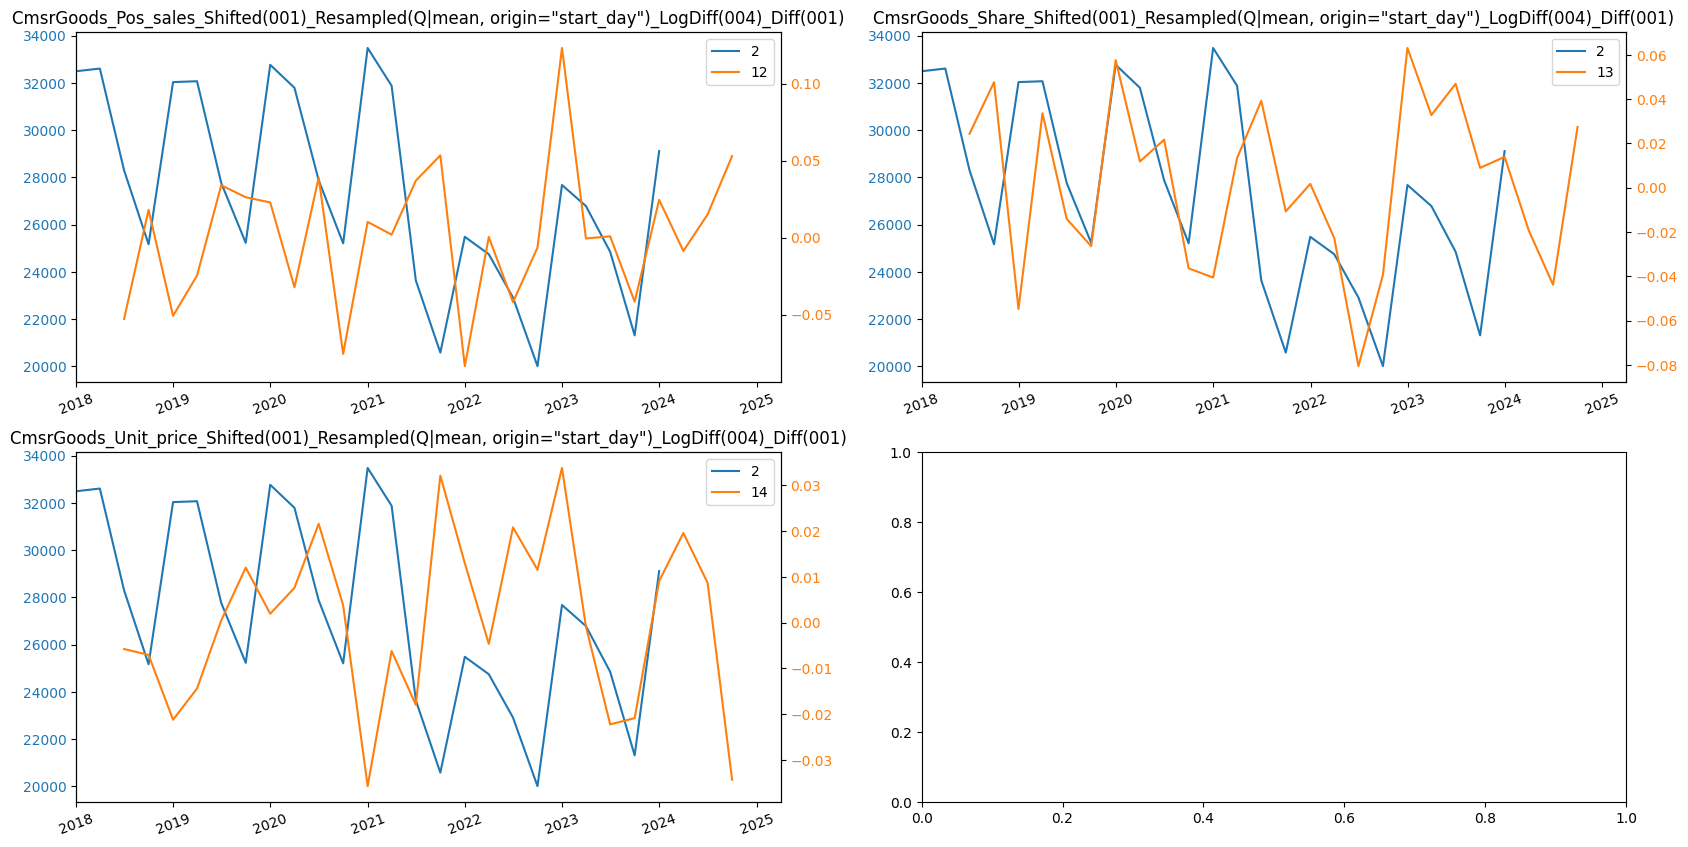

In [29]:
start_date='2018-01-01'

sdh.show_line_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[:4],
    start_date=start_date,
    col_num=2,
    chunk_size=6,
)

For each target (ticker), draw a line plot of the KPI (y) and the variable (x).

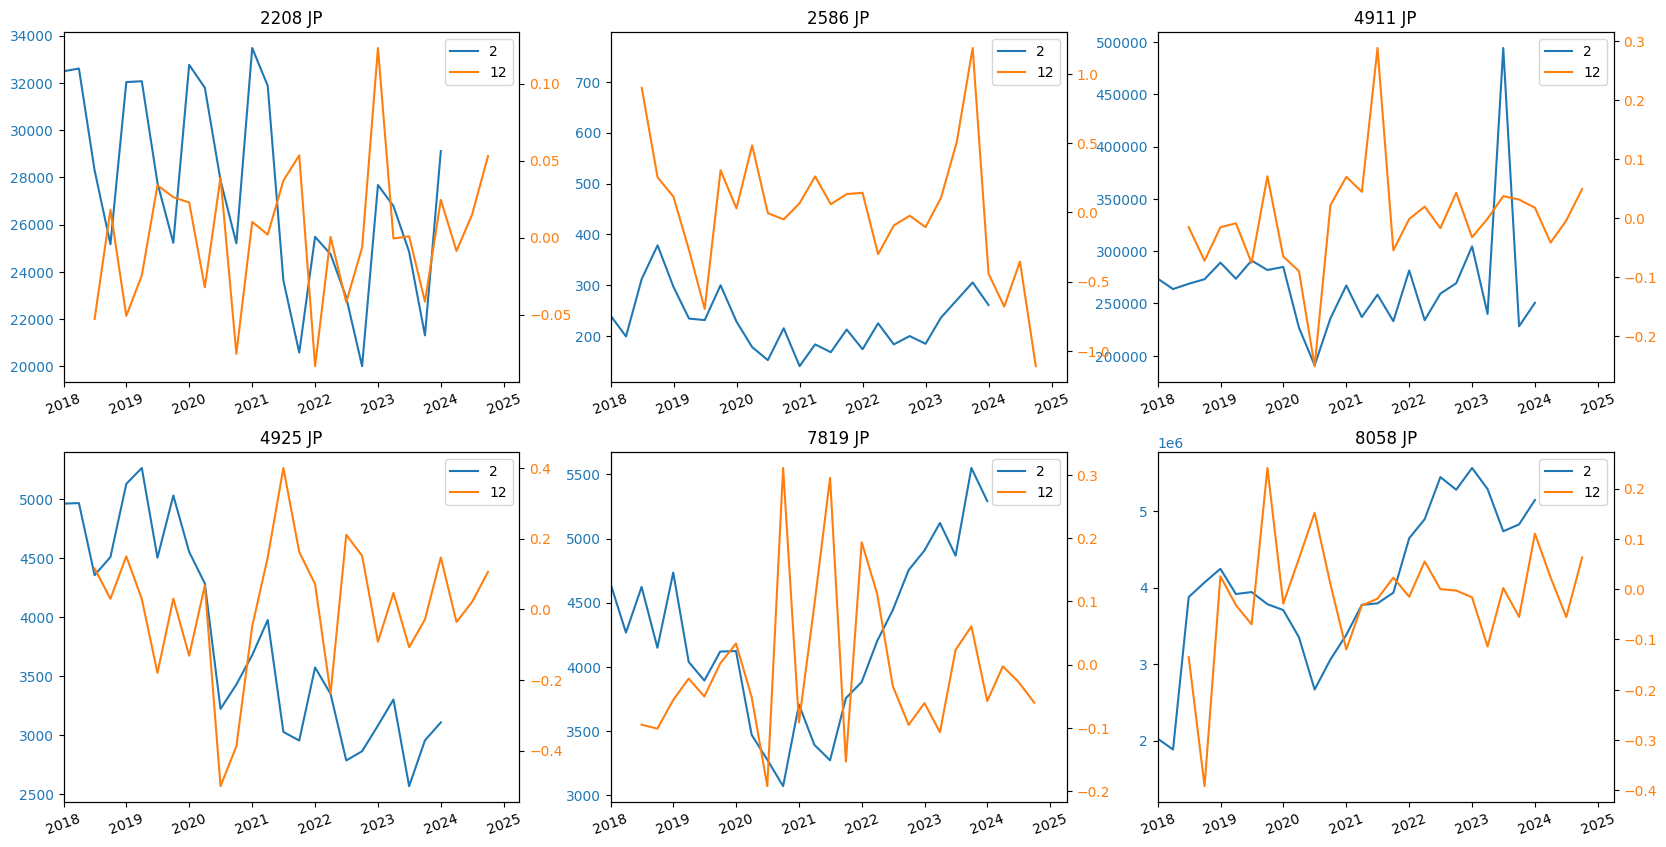

In [30]:
sdh.show_line_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    chunk_size=6)


### Plot Scatter

Draw a scatter plot of the KPI (y) and other variables (X) for the specified target (ticker).

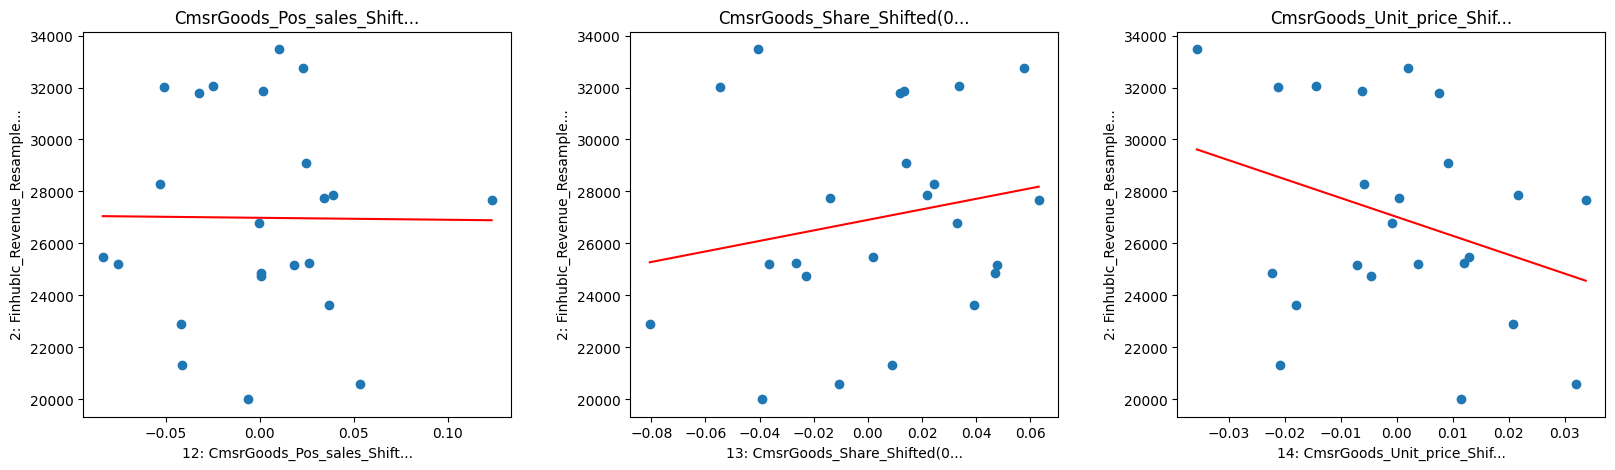

In [31]:
sdh.show_scatter_one_target(
    target=tickers[0],
    y=kpi,
    X=alt_W_shift_1_ids[-6:],
    start_date=start_date,
    col_num=3,
    vname_len_limit=25,
)

Draw scatter plots of the KPI (y) and variable (x) for each target (ticker).

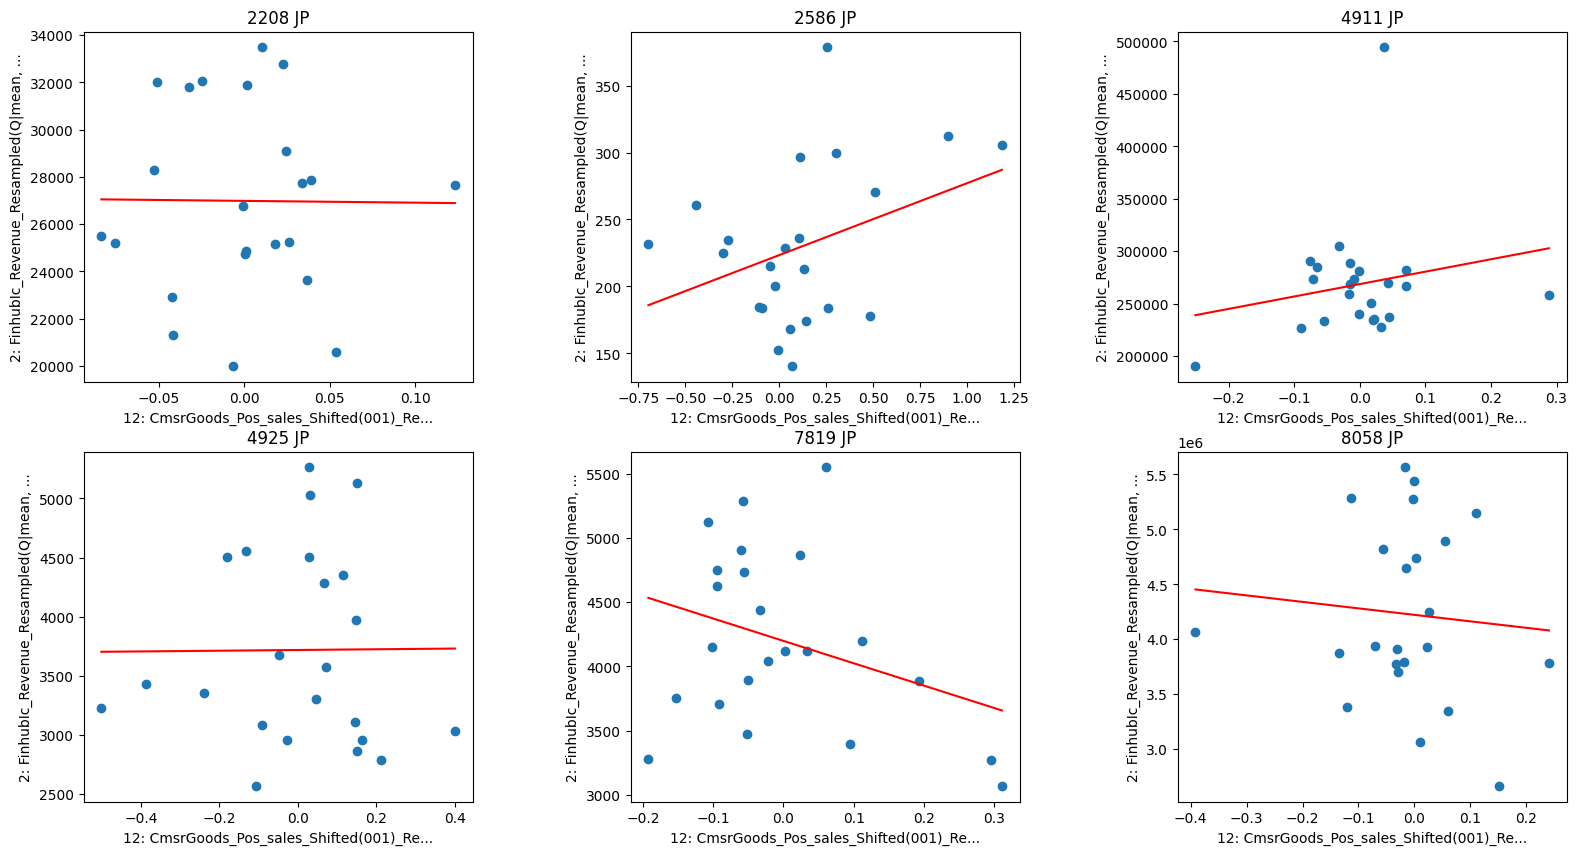

In [32]:
sdh.show_scatter_per_target(
    y=kpi,
    x=alt_W_shift_1_ids[0],
    # targets=tickers,
    start_date=start_date,
    col_num=3,
    vname_len_limit=35,
)